## Vishnu Arun

#### News Headlines Data Set Analysis

Million News headlines Dataset: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/SYBGZL

Our Dataset contains a large number of news headlines from an autralian news network. It contians a volume of 200 articles per day and a good focus on international news.

We can see all the important episodes shaping the last decade and how they evolved over time. Ex: financial crisis, iraq war, multiple US elections, ecological disasters, terrorism, famous people, Australian crimes etc.

#### Business Proposal
We can sort our headlines into appropriate categories, better understand how language is reported in new headlines, and use insights to analysze trends in the news over time. We can also perform sentimental analysis to quantify the tonal qualities of the headlines. We can also automate headline generation using a Markov Chain. Although random headlines aren't indicative of real stories, but these random generations can be used to understand structure and format of previous headlines. 

In the future we can combine this dataset with the number of viewers per airing or total engagement time to judge the effectivness of the headlines and engagement. This insight can be used in the broadcasting companies marketing to better construct engaging headlines. 



#### Import Statements

In [48]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

%matplotlib inline

# Word-cloud 
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords;


# K-means portion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

#### Read in Dataset

In [2]:
Newsdatafile = "/Users/vishnu/Desktop/abcnews-date-text.v6.csv"

raw_data = pd.read_csv(Newsdatafile, parse_dates=[0], infer_datetime_format=True)

reindexed_data = raw_data['headline_text']
reindexed_data.index = raw_data['publish_date']

display(raw_data.head())

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


## Exploratory Data Analysis

#### Finding top words over all records

We can find all the top important words over all the records in this dataset. We remove all stop words and filler before conducting our analysis.

In [3]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''returns a tuple of the top n words in a sample and their accompanying counts, given a CountVectorizer object and text sample'''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.as_matrix())
    
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

Text(0.5,1,'Top Words')

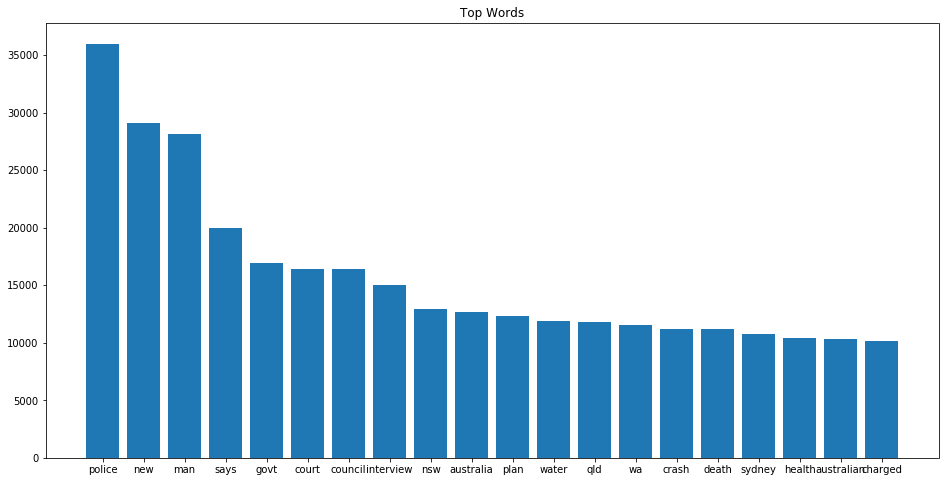

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=20, count_vectorizer=count_vectorizer, text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words)
ax.set_title('Top Words')

#### Frequency of Data over time

We can see the frequency of articles published over time. We display in Daily, Monthly, and Yearly counts.

Text(0.5,1,'Yearly Counts')

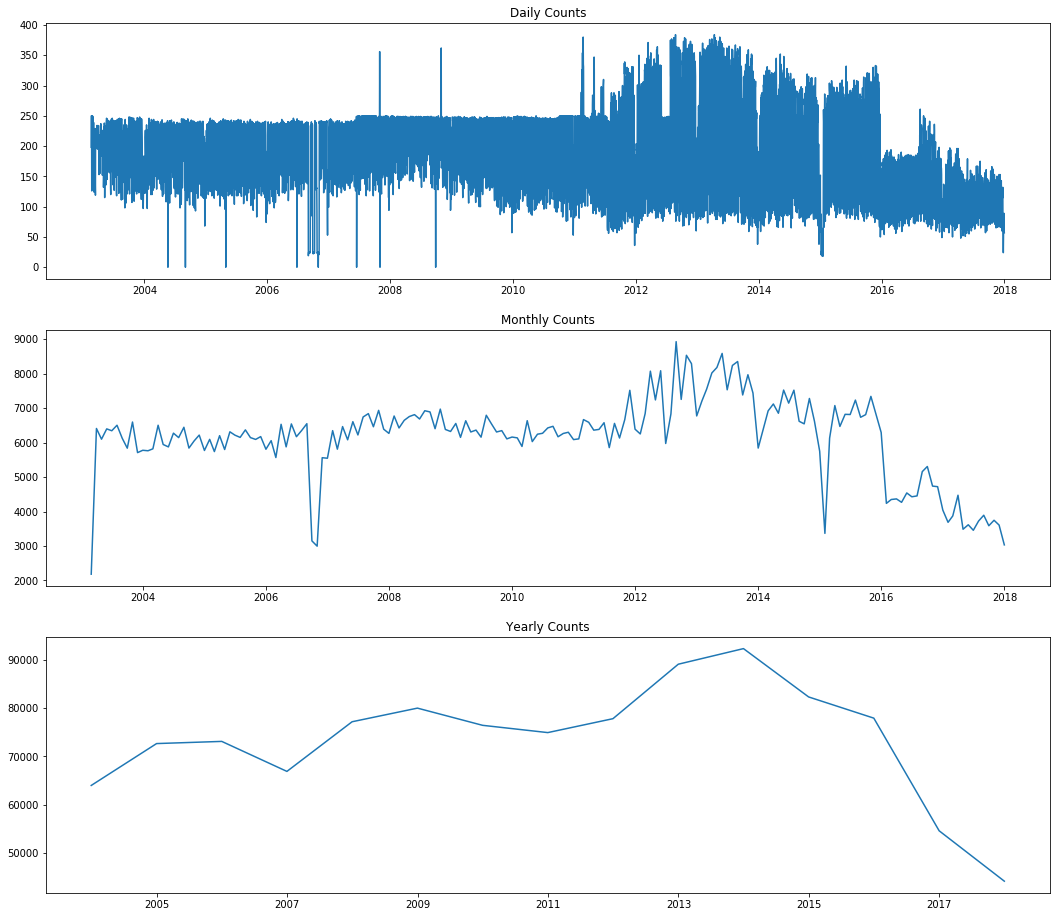

In [5]:
monthly_counts = reindexed_data.resample('M').count()
yearly_counts = reindexed_data.resample('A').count()
daily_counts = reindexed_data.resample('D').count()

fig, ax = plt.subplots(3, figsize=(18,16))
ax[0].plot(daily_counts)
ax[0].set_title('Daily Counts')
ax[1].plot(monthly_counts)
ax[1].set_title('Monthly Counts')
ax[2].plot(yearly_counts)
ax[2].set_title('Yearly Counts')

#### Word cloud plot

We can visualize our dataseet using this graphic. The larger font words have a higher frequency in our dataset.

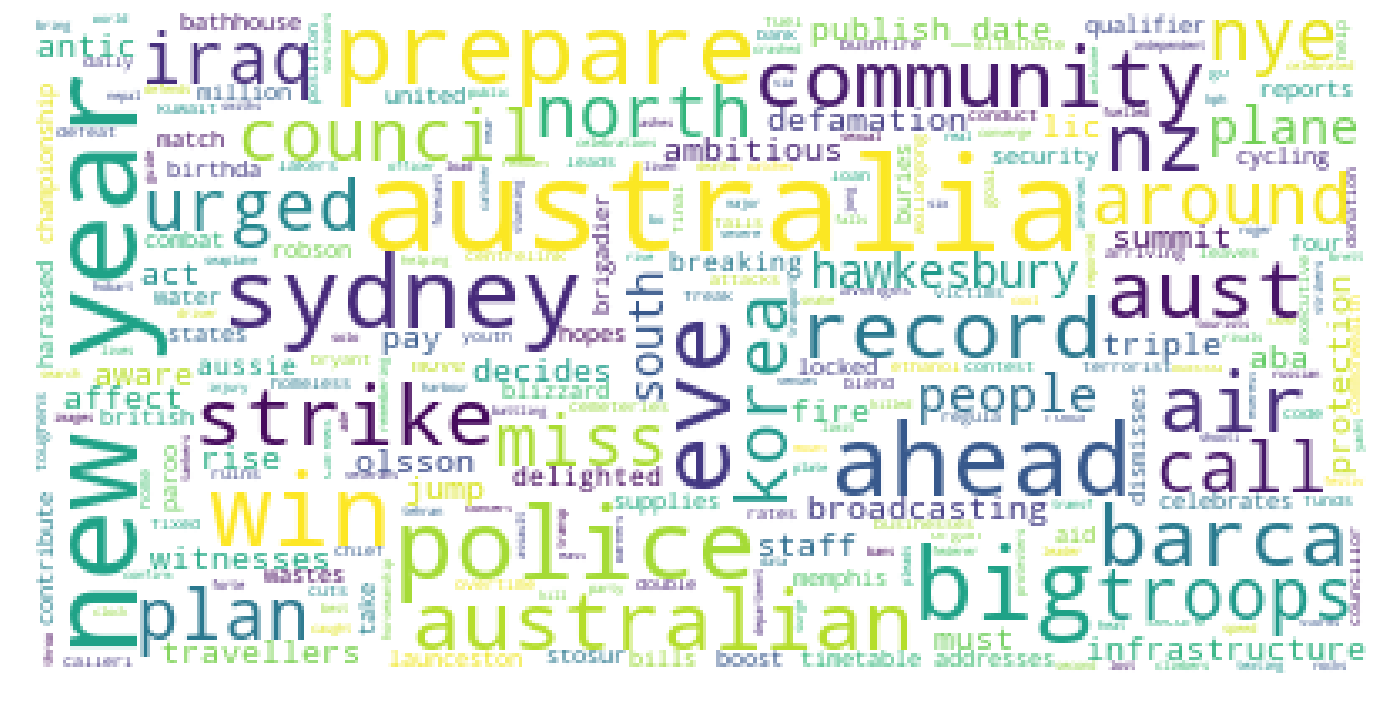

In [59]:
stopwords1 = stopwords.words()
wordcloud = WordCloud( background_color='white', stopwords=stopwords1, 
                      max_words=300, max_font_size=40, random_state=41).generate(str(raw_data['headline_text']))
fig = plt.figure(figsize=(24,24))
#fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Word vectorization

We need to convert all words to vectors. This allows us to apply the dataset to a number of different algorithms that take in vectors.

In [6]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
small_text_sample = reindexed_data.sample(n=10000, random_state=0).as_matrix()

print('Headline before vectorization: ', small_text_sample[123])

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n', small_document_term_matrix[123])

Headline before vectorization:  mcewen mp says new labor leadership process will make party mor
Headline after vectorization: 
   (0, 7268)	1
  (0, 8063)	1
  (0, 6740)	1
  (0, 8616)	1
  (0, 7337)	1
  (0, 6925)	1
  (0, 6250)	1
  (0, 7543)	1
  (0, 6365)	1
  (0, 9710)	1


In [7]:
n_topics = 8

### Latent Semantic Analysis
LSA is simply a large truncated SVD docuemt-term matrix with very high rank and sparsity. Our n_topics represent the largest singular values preserved. 

LSA assumes that words that are close in meaning will occur in similar pieces of text. 

We construct a matrix from a large piece of text and the SVD technique (to reduce the number of rows while preserving the structure). Thi matrix contains word counts per paragraph (rows represent unique words and columns represent each paragraph).

We can compare words using vector comparison technique such as consine distance.


In [8]:
from sklearn.decomposition import TruncatedSVD

lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [9]:
# Define helper functions
def get_keys(topic_matrix):
    '''returns an integer list of predicted topic categories for a given topic matrix'''
    keys = []
    for i in range(topic_matrix.shape[0]):
        keys.append(topic_matrix[i].argmax())
    return keys

def keys_to_counts(keys):
    '''returns a tuple of topic categories and their accompanying magnitudes for a given list of keys'''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [10]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [11]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''returns a list of n_topic strings, where each string contains the n most common 
        words in a predicted category, in order'''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

Using LSA we can predict top news categories using a small sample of headlines. Each topic is category is described using 3 words.

In [12]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i), top_n_words_lsa[i])

Topic 0:  police death crash missing probe search years year drug body
Topic 1:  new laws zealand chinese sets coach opens air research prices
Topic 2:  man sydney dies murder charged jailed accused attack guilty car
Topic 3:  says world cup group power labor market iraq win day
Topic 4:  govt health qld plan wa nsw australia australian water sa
Topic 5:  court face trial high faces told case murder ban hears
Topic 6:  council gold coast backs plan land dog bay sell rates
Topic 7:  interview nrl peter speaks extended john david adam cooper michael


Text(0.5,1,'LSA Topic Category Counts')

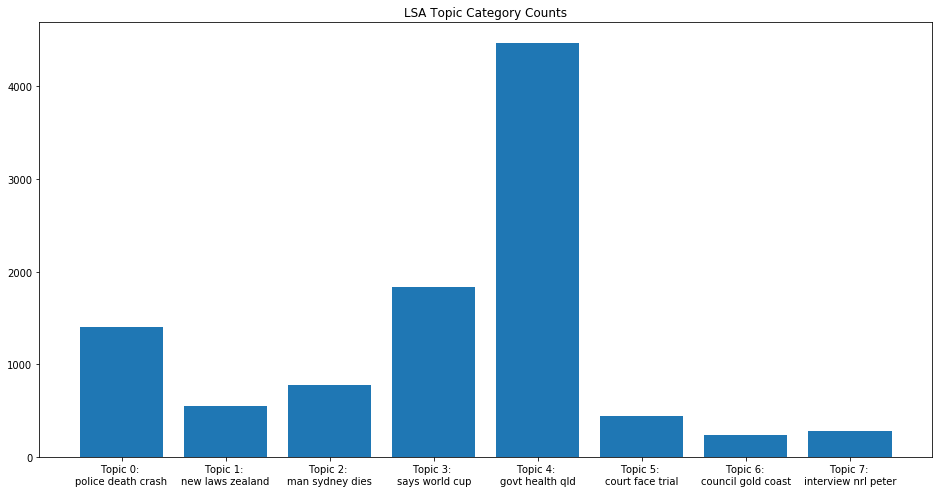

In [45]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts)
ax.set_xticks(lsa_categories)
ax.set_xticklabels(labels)
ax.set_title('LSA Topic Category Counts')

### Automated Headline Generator

Markov Chain Implementation.

A Markov chain decribes a sequence of possible events represented as states where the probablitiy of each event only depends on the state prior. We can define our sequence of events as words in a sentence and weight probablities based on freqency and recency of words. We train the Markov model using our dataset and obtain a model that no longer requres the training data to operate. This allows Markov models to be memory effective.

Headlines are constructed based on word choices, structure, and word choice from previous headlines used in the training set. Interestingly Twitter bots are constructed with similar logic.

In [19]:
import markovify

In [20]:
# State size 2
text_model = markovify.NewlineText(raw_data.headline_text, state_size = 2)

In [47]:
for i in range(20):
    print(text_model.make_sentence())

police charge man over freeway stand off
clean up after storm hits hard across south west towns
abc defends tv licence fee
labor vows penalties for wayward cows
afghanistan rocks out with a bang
developer welcomes inquiry findings may be easing
former commissioner voices concern over exposed gas pipeline to cut plastic bag suppliers facing accc complaint over world heritage forest objections
abbott announces commitment to tafe funding
frog research to target continued eat local thursday market
one plus one: jack charles labels taxi driver charged over afghan commitment reaffirmed despite deaths
ronaldinho may be fined if you wont
yasi rebuild costing more than one million australians researchers
shares close higher with resurgent finance sector qantas boost market
program aims to better estimate chemical use
man jailed for trafficking women
china combats bird flu test
share price continues declining trend
photographer describes view of the year backed council wiradjuri elder explains p

In [23]:
text_model1 = markovify.NewlineText(raw_data.headline_text, state_size = 3)

In [39]:
for i in range(34):
    if (text_model1.make_sentence() != None):
        print(text_model1.make_sentence())
    else:
        print()

adelaide bite baseballer fails show court arrest warrant for former president
learn clues on how to become a dad
extended interview with andrew fraser


alleged thief agrees to sell cliff head interest
None
south burnett cattle producers call for improved flood warning after heavy rain cuts roads
woman arrested twice for drink driving in dog squad van
None
drug users urged to oppose ir changes

prisoner kept brown snake in her ugg boot
None
hotels left out of team table tennis
canberra man charged as police smash drug ring linked to gypsy jokers

qld police may call in help to catch model camera
manchester attack survivor feared for her life after abduction ordeal
None
phelps denied eighth gold as us relay team stripped of sydney gold
khawaja happy to keep hewitt dispute out of court settlement in artworks case
west coast eagles hit by waters blow
geraldton storm cuts power to bayside homes
rescue chopper searches for missing after avalanche in nepal
None
barmera man avoids jail over c